# Presentation Notebook for The **Simulators**

The first step to using our package is to validate the contents.
This function called **validate_power_system_simulation** will ensure that the input data is compatible with **all** of the functionalities of this package and throw an exception if it doesn't. 

All possible exceptions not included in the base **Power_Grid_model** package are:
- TimestampsDoNotMatchError
- LoadIdsDoNotMatchError
- IDNotFoundError
- InputLengthDoesNotMatchError
- IDNotUniqueError
- GraphNotFullyConnectedError
- GraphCycleError
- EdgeAlreadyDisabledError
- TooManyTransformers
- TooManySources
- NotAllFeederIDsareValid
- TransformerAndFeedersNotConnected
- TooFewEVs
  
These exceptions each come with an explanation of the issue which is needed to ensure that none of the data will fail in the rest of the function. However the actual check may take a long time with larger input data sizes to potentially quite a long time.

First step to using this package will always be defining the location of the input files and data

In [81]:
from pathlib import Path
import pandas as pd

from src.power_system_simulation.graph_processing import GraphProcessor
from src.power_system_simulation import calculation_module as calc
from src.power_system_simulation import validate_power_system_simulation as validate
DATA_PATH = Path.cwd() / "tests" / "data" / "Exception_test_data"

metadata = DATA_PATH / "meta_data.json"
input_network = DATA_PATH / "input_network_data.json"
active_power_profile = DATA_PATH / "active_power_profile.parquet"
reactive_power_profile = DATA_PATH / "reactive_power_profile.parquet"
ev_active_power_profile = DATA_PATH / "ev_active_power_profile.parquet"

Next The validate function is called which checks for all the possible errors visible in the top section

In [82]:
validate.validate_power_system_simulation(input_network, metadata, active_power_profile, reactive_power_profile,ev_active_power_profile)

Next the various functions of the package include: 
- making a graph
- visualizing a graph 
- finding a downstream vertice
- finding alternative edges
- Powergrid power calculations 
- finding an optimal tap position
- EV penetration level 
- N-1 calculation

## Making a graph
- A class for processing undirected graphs.
- This class provides functionality to initialize a graph, find downstream vertices of an edge, and identify alternative edges for ensuring graph connectivity.

Attributes:
- graph: A NetworkX graph representing the processed graph.

Args:
- vertex_ids (List[int]): List of vertex IDs.
- edge_ids (List[int]): List of edge IDs.
- edge_vertex_id_pairs (List[Tuple[int, int]]): List of tuples - - representing vertex pairs for each edge.
- edge_enabled (List[bool]): List indicating whether each edge is - enabled (True) or disabled (False).
- source_vertex_id (int): ID of the source vertex.

Raises:
- IDNotUniqueError: If there are duplicate vertex or edge IDs.
- InputLengthDoesNotMatchError: If the length of edge_enabled does not match the input lists edge_ids.
- IDNotFoundError: If a vertex ID present in edge_vertex_id_pairs does not exist in vertex_ids.
- GraphNotFullyConnectedError: If the graph is not fully connected.
- GraphCycleError: If the graph contains cycles.

To demonstrate the functionality of the class, the grid can be created as follows:

In [83]:
vertex_ids = [0, 2, 4, 6, 10]
edge_ids = [1, 3, 5, 7, 8, 9]
edge_vertex_id_pairs = [(0, 2), (0, 4), (0, 6), (2, 4), (4, 6), (2, 10)]
edge_enabled = [True, True, True, False, False, True]
source_vertex_id = 10

grid = GraphProcessor(vertex_ids, edge_ids, edge_vertex_id_pairs, edge_enabled, source_vertex_id)

## Visualizing a graph
Here Carmelo's graph code
Here some explaination

Now, the graph can be visualized as follows:

## Finding a downstream vertice
 Args:
- starting_edge_id (int): ID of the edge to find downstream vertices for.

Returns:
- List[int]: List of vertex IDs downstream from the specified edge.

### Working Principle:
- Verify that the edge ID exists
- Check if the edge is already disabled, which would be 
- Get the vertices of the edge
- Simulate the edge being disabled by temporarily removing it
- Find all connected components after the removal
- Restore the edge to maintain original graph state
- Determine which component contains the source vertex
- Return the nodes in the component that does not contain the source vertex


In [84]:
downstream_vertices = grid.find_downstream_vertices(1)
downstream_vertices

[0, 4, 6]

## Finding alternative edges
Args:
- disabled_edge_id (int): The ID of the edge to be disabled.

Returns:
- List[int]: A list of alternative edge IDs.

### Working principle:
- a list of ORIGINALLY disabled edges is created
- errors are checked and empty output list is initialised
- a list of UPDATED disabled edges is made with disabled_edge_id considered
- a list of edges is created: the list(zip()) functions pair each edge_id with the corresponding vertex pair and status-enables/disabled
-  a new list is made where disabled_edge_id considered (it becomes disabled)
-  the ORIGINALLY disabled edges are taken one by one (while loop). For each iteration, the edge is now ENABLED "temporarily" and a new graph is made. This graph is then checked for cyclicity and completeness. If satisfactory, the ORIGINALLY disabled index is added to the output list alt_list[]
- after iterations end, the output list is printed

[7]

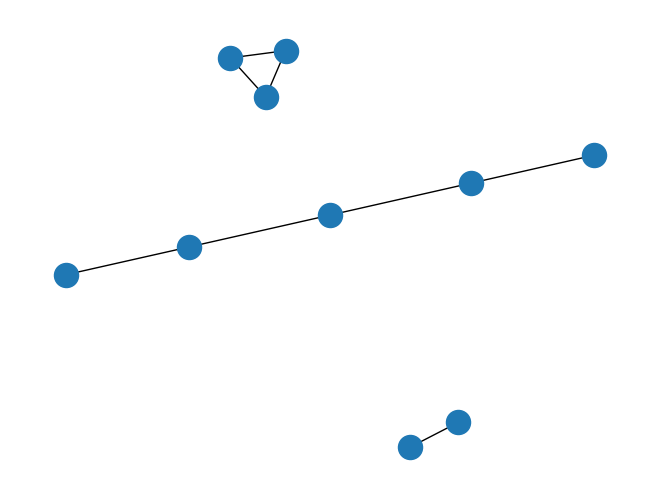

In [85]:
alternative_edges = grid.find_alternative_edges(1)
alternative_edges

# Large Powergrid
now we have seen how a small graph can be created, a large powergrid is loaded for the following sections.

## Powergrid power calculations:
- Analyze power flow on the given power grid network using provided active and reactive power profile data.

function: 
- calculate_power_grid()

Args:
- input_network_data (Dict): Input network data in JSON format.
- active_power_profile_path (str): Path to the parquet file containing active power profile data.
- reactive_power_profile_path (str): Path to the parquet file containing reactive power profile data.

Returns:
- Dict: Aggregated power flow results containing voltage statistics and line loading information.

### Working Principle:
- Load input network data
- Validate input data
- Load active and reactive power profiles
- Check if timestamps and load IDs match
- Create PGM batch update dataset
- Validate batch data
- Run power flow calculations
- Aggregating voltage results
- Aggregating line loading results
- Create DataFrame for voltage results
- Create DataFrame for line results
- Return aggregated results

In [86]:
from src.power_system_simulation.calculation_module import (
    calculate_power_grid,
)

voltage_results, line_results = calculate_power_grid(
        input_network, active_power_profile, reactive_power_profile
)
voltage_results

,Max_Voltage,Max_Voltage_Node,Min_Voltage,Min_Voltage_Node
Timestamp,,,,
2025-01-01 00:00:00,1.072931,1,1.049819,0
2025-01-01 00:15:00,1.075911,1,1.050022,0
2025-01-01 00:30:00,1.069725,1,1.049603,0
2025-01-01 00:45:00,1.073244,1,1.049842,0
2025-01-01 01:00:00,1.072924,1,1.049819,0
...,...,...,...,...
2025-01-10 22:45:00,1.071457,1,1.049730,0
2025-01-10 23:00:00,1.075341,1,1.049993,0
2025-01-10 23:15:00,1.072623,1,1.049803,0


In [87]:
print("Line Results:")
line_results

Line Results:


,Total_Loss,Max_Loading,Max_Loading_Timestamp,Min_Loading,Min_Loading_Timestamp
Line_ID,,,,,
16,26.709511,6.869324e-05,2025-01-04 06:30:00,1.253601e-05,2025-01-08 12:30:00
17,1.128073,1.653650e-03,2025-01-04 09:45:00,2.697708e-04,2025-01-08 11:30:00
18,9.100636,3.414478e-05,2025-01-07 10:45:00,5.617314e-06,2025-01-05 17:45:00
19,1.220324,1.543576e-03,2025-01-07 10:45:00,2.496785e-04,2025-01-05 17:45:00
20,27.361620,7.086133e-05,2025-01-07 10:45:00,1.172002e-05,2025-01-02 14:30:00
21,1.132925,1.658966e-03,2025-01-07 10:30:00,2.550110e-04,2025-01-02 14:30:00
22,8.584028,3.876018e-05,2025-01-07 10:45:00,5.715455e-06,2025-01-02 12:30:00
23,1.345700,1.500068e-03,2025-01-07 10:45:00,2.202110e-04,2025-01-02 12:30:00
24,2.725758,2.452007e-07,2025-01-10 21:15:00,2.418978e-07,2025-01-04 09:45:00


## Finding an optimal tap position

## EV penetration level 

## N-1 calculation